In [1]:
import cv2
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from natsort import natsorted
import numpy as np
import pandas as pd

In [2]:
train=pd.read_csv('Training_set.csv')
train

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART
...,...,...
6494,Image_6495.jpg,MANGROVE SKIPPER
6495,Image_6496.jpg,MOURNING CLOAK
6496,Image_6497.jpg,APPOLLO
6497,Image_6498.jpg,ELBOWED PIERROT


In [3]:
train_dir=Path('train/')

In [4]:
train_images = natsorted(list(map(str, list(train_dir.glob("*.jpg")))))
train_images

['train\\Image_1.jpg',
 'train\\Image_2.jpg',
 'train\\Image_3.jpg',
 'train\\Image_4.jpg',
 'train\\Image_5.jpg',
 'train\\Image_6.jpg',
 'train\\Image_7.jpg',
 'train\\Image_8.jpg',
 'train\\Image_9.jpg',
 'train\\Image_10.jpg',
 'train\\Image_11.jpg',
 'train\\Image_12.jpg',
 'train\\Image_13.jpg',
 'train\\Image_14.jpg',
 'train\\Image_15.jpg',
 'train\\Image_16.jpg',
 'train\\Image_17.jpg',
 'train\\Image_18.jpg',
 'train\\Image_19.jpg',
 'train\\Image_20.jpg',
 'train\\Image_21.jpg',
 'train\\Image_22.jpg',
 'train\\Image_23.jpg',
 'train\\Image_24.jpg',
 'train\\Image_25.jpg',
 'train\\Image_26.jpg',
 'train\\Image_27.jpg',
 'train\\Image_28.jpg',
 'train\\Image_29.jpg',
 'train\\Image_30.jpg',
 'train\\Image_31.jpg',
 'train\\Image_32.jpg',
 'train\\Image_33.jpg',
 'train\\Image_34.jpg',
 'train\\Image_35.jpg',
 'train\\Image_36.jpg',
 'train\\Image_37.jpg',
 'train\\Image_38.jpg',
 'train\\Image_39.jpg',
 'train\\Image_40.jpg',
 'train\\Image_41.jpg',
 'train\\Image_42.jpg',
 

In [5]:
train_labels=list(train['label'])
train_labels

['SOUTHERN DOGFACE',
 'ADONIS',
 'BROWN SIPROETA',
 'MONARCH',
 'GREEN CELLED CATTLEHEART',
 'CAIRNS BIRDWING',
 'GREEN CELLED CATTLEHEART',
 'EASTERN DAPPLE WHITE',
 'BROWN SIPROETA',
 'RED POSTMAN',
 'MANGROVE SKIPPER',
 'BLACK HAIRSTREAK',
 'CABBAGE WHITE',
 'RED ADMIRAL',
 'PAINTED LADY',
 'MANGROVE SKIPPER',
 'PAPER KITE',
 'SOOTYWING',
 'PINE WHITE',
 'PEACOCK',
 'CHECQUERED SKIPPER',
 'JULIA',
 'COMMON WOOD-NYMPH',
 'BLUE MORPHO',
 'CLOUDED SULPHUR',
 'STRAITED QUEEN',
 'ORANGE OAKLEAF',
 'PURPLISH COPPER',
 'CLOUDED SULPHUR',
 'ATALA',
 'IPHICLUS SISTER',
 'CAIRNS BIRDWING',
 'CAIRNS BIRDWING',
 'BLACK HAIRSTREAK',
 'DANAID EGGFLY',
 'PAINTED LADY',
 'LARGE MARBLE',
 'DANAID EGGFLY',
 'PIPEVINE SWALLOW',
 'BLUE SPOTTED CROW',
 'LARGE MARBLE',
 'EASTERN DAPPLE WHITE',
 'LARGE MARBLE',
 'PAINTED LADY',
 'RED CRACKER',
 'QUESTION MARK',
 'CRIMSON PATCH',
 'BANDED PEACOCK',
 'CHECQUERED SKIPPER',
 'DANAID EGGFLY',
 'RED POSTMAN',
 'COMMON WOOD-NYMPH',
 'SCARCE SWALLOW',
 'DANAID EG

In [6]:
target_class=list(set(label for label in train_labels))

In [7]:
target_class

['INDRA SWALLOW',
 'MESTRA',
 'GREAT JAY',
 'LARGE MARBLE',
 'CABBAGE WHITE',
 'GREEN CELLED CATTLEHEART',
 'MOURNING CLOAK',
 'BECKERS WHITE',
 'RED SPOTTED PURPLE',
 'ORANGE TIP',
 'SLEEPY ORANGE',
 'ORANGE OAKLEAF',
 'PIPEVINE SWALLOW',
 'PURPLE HAIRSTREAK',
 'EASTERN PINE ELFIN',
 'MONARCH',
 'AMERICAN SNOOT',
 'CRECENT',
 'DANAID EGGFLY',
 'COPPER TAIL',
 'GREAT EGGFLY',
 'ATALA',
 'ZEBRA LONG WING',
 'POPINJAY',
 'BLUE SPOTTED CROW',
 'RED CRACKER',
 'CHECQUERED SKIPPER',
 'ELBOWED PIERROT',
 'EASTERN COMA',
 'STRAITED QUEEN',
 'RED ADMIRAL',
 'ULYSES',
 'PAINTED LADY',
 'CLOUDED SULPHUR',
 'MILBERTS TORTOISESHELL',
 'SOUTHERN DOGFACE',
 'IPHICLUS SISTER',
 'BANDED PEACOCK',
 'PURPLISH COPPER',
 'GREY HAIRSTREAK',
 'VICEROY',
 'EASTERN DAPPLE WHITE',
 'MANGROVE SKIPPER',
 'CLODIUS PARNASSIAN',
 'PEACOCK',
 'ORCHARD SWALLOW',
 'YELLOW SWALLOW TAIL',
 'BROWN SIPROETA',
 'SILVER SPOT SKIPPER',
 'QUESTION MARK',
 'GOLD BANDED',
 'PAPER KITE',
 'CLEOPATRA',
 'COMMON WOOD-NYMPH',
 'AN 

In [8]:
len(target_class)

75

In [9]:
img_width=128
img_height=128
batch_size=10

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
le=LabelEncoder()
encoded_train_labels=le.fit_transform(train_labels)
le.classes_

array(['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88',
       'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK',
       'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO',
       'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE',
       'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA',
       'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL',
       'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH',
       'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE',
       'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED',
       'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART',
       'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA',
       'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA',
       'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK',
       'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY',
       'PAPER KITE', 'PEACOCK', 'PINE WHIT

In [12]:
augmentor=keras.Sequential([
    keras.layers.GaussianNoise(.01),
    keras.layers.RandomTranslation(height_factor=0.1,width_factor=0.1,fill_mode='constant',fill_value=0.0),
    keras.layers.RandomContrast(0.2),
    keras.layers.RandomBrightness(0.1,value_range=(0,1))
])

In [13]:
def image_preprocessing(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(img_width,img_height))
    img=img/255.0
    return img

In [14]:
def train_image_preprocessing(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(img_width,img_height))
    img=img/255.0
    img=augmentor(img,training=True)
    img=img.numpy().astype('float64')
    return img

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train,x_val,y_train,y_val=train_test_split(np.array(train_images),np.array(encoded_train_labels),test_size=0.2,random_state=42)

In [17]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((5199,), (5199,), (1300,), (1300,))

In [18]:
x_train=np.array(list(map(train_image_preprocessing,x_train)))
x_val=np.array(list(map(image_preprocessing,x_val)))

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [20]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [21]:
validation_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [22]:
import matplotlib.pyplot as plt

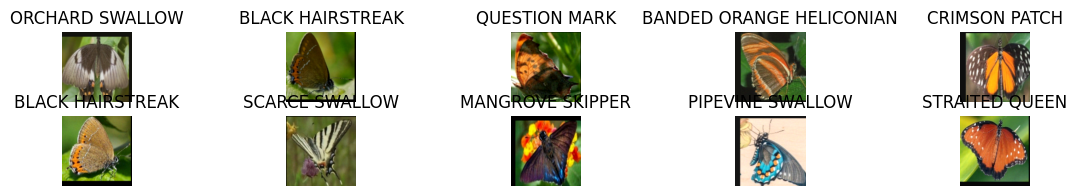

In [23]:
_, ax = plt.subplots(2, 5, figsize=(14, 2))
for batch in train_dataset.take(1):
    images = batch[0]
    labels = batch[1]
    for i in range(batch_size):
        img = (images[i] * 255).numpy().astype("uint8")
        label=labels[i]
        label=label.numpy()
        label=le.classes_[label]
        ax[i//5,i%5].imshow(img)
        ax[i//5,i%5].set_title(label)
        ax[i//5,i%5].axis("off")

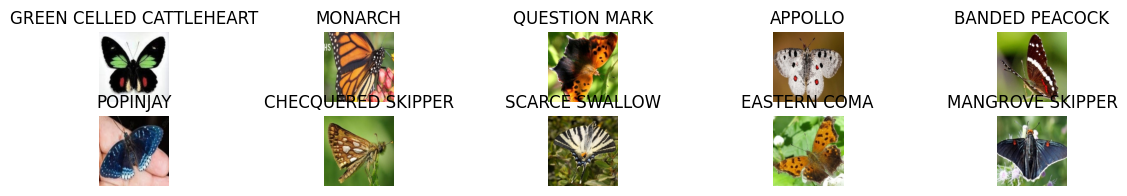

In [24]:
_, ax = plt.subplots(2, 5, figsize=(14, 2))
for batch in validation_dataset.take(1):
    images = batch[0]
    labels = batch[1]
    for i in range(batch_size):
        img = (images[i] * 255).numpy().astype("uint8")
        label=labels[i]
        label=label.numpy()
        label=le.classes_[label]
        ax[i//5,i%5].imshow(img)
        ax[i//5,i%5].set_title(label)
        ax[i//5,i%5].axis("off")

In [25]:
def build_model():
    input_img=keras.Input(shape=(img_width,img_height,3),name='image')

    x = keras.layers.Conv2D(
        32,
        (3, 3),
    )(input_img)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    
    x = keras.layers.Conv2D(
        64,
        (3, 3),
    )(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    
    x = keras.layers.Conv2D(
        128,
        (3, 3),
    )(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x=keras.layers.GlobalMaxPooling2D()(x)

    x=keras.layers.Dense(128,activation='relu')(x)
    x=keras.layers.Dropout(0.2)(x)

    x=keras.layers.Dense(len(target_class),activation='softmax')(x)
    
    model=keras.models.Model(inputs=input_img,outputs=x)
    opt=keras.optimizers.Adam(learning_rate=1e-3, decay=1e-3)
    model.compile(optimizer=opt,loss=keras.losses.SparseCategoricalCrossentropy(),metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model

In [26]:
model=build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496 

In [27]:
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
lr_scheduler=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-5)

In [28]:
history=model.fit(train_dataset,validation_data=validation_dataset,epochs=100,callbacks=[early_stop,lr_scheduler])

Epoch 1/100
520/520 [==============================] - 16s 23ms/step - loss: 4.0996 - sparse_categorical_accuracy: 0.0521 - val_loss: 3.6349 - val_sparse_categorical_accuracy: 0.1208 - lr: 0.0010
Epoch 2/100
520/520 [==============================] - 11s 21ms/step - loss: 3.5068 - sparse_categorical_accuracy: 0.1262 - val_loss: 3.0064 - val_sparse_categorical_accuracy: 0.2431 - lr: 0.0010
Epoch 3/100
520/520 [==============================] - 11s 21ms/step - loss: 2.9907 - sparse_categorical_accuracy: 0.2264 - val_loss: 2.5681 - val_sparse_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 4/100
520/520 [==============================] - 11s 21ms/step - loss: 2.5643 - sparse_categorical_accuracy: 0.3168 - val_loss: 2.1994 - val_sparse_categorical_accuracy: 0.4362 - lr: 0.0010
Epoch 5/100
520/520 [==============================] - 11s 21ms/step - loss: 2.2132 - sparse_categorical_accuracy: 0.4120 - val_loss: 2.0198 - val_sparse_categorical_accuracy: 0.4631 - lr: 0.0010
Epoch 6/100
520/520 

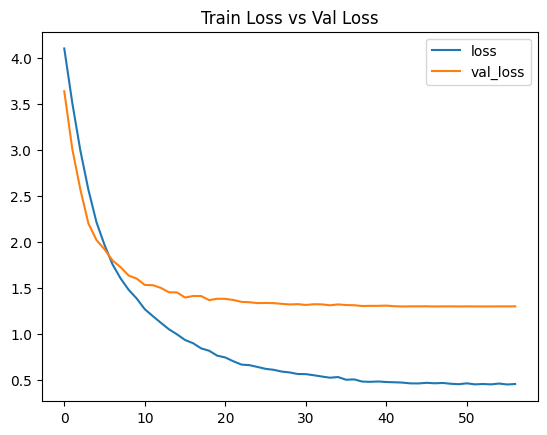

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.title('Train Loss vs Val Loss')
plt.show()

In [33]:
model.save('Butterfly_Classif.h5')